## Hands-on tutorials - Fourier Neural Operator for 1D Burgers equation

- Author: Xiaoyu Xie
- Email: xiaoyuxie2020@u.northwestern.edu
- Date: January 13, 2024

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.io import loadmat

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

/home/xxd5545/.conda/envs/torch2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define FNO model

In [2]:
class SpectralConv1d(nn.Module):
    """
    Spectral Convolutional 1D Layer.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        modes1 (int): Number of Fourier modes to multiply, at most floor(N/2) + 1.

    Attributes:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        modes1 (int): Number of Fourier modes to multiply, at most floor(N/2) + 1.
        scale (float): Scaling factor for the weights.
        weights1 (nn.Parameter): Learnable weights for the convolution.

    Methods:
        compl_mul1d(input, weights): Performs complex multiplication between input and weights.
        forward(x): Forward pass of the SpectralConv1d layer.
    """

    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes are kept, at most floor(N/2) + 1

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    def compl_mul1d(self, input, weights):
        """
        Performs complex multiplication between input and weights.

        Args:
            input (torch.Tensor): Input tensor of shape (batch, in_channel, x).
            weights (torch.Tensor): Weights tensor of shape (in_channel, out_channel, x).

        Returns:
            torch.Tensor: Result of complex multiplication of input and weights, of shape (batch, out_channel, x).
        """
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        # in_channel is the common dimension along which the operation is performed. 
        # It suggests that every channel (or feature) of the input is being transformed into a new set of channels (or features) in the output.
        # The operation iterates over each batch and each position x, multiplying the input channels 
        # by the corresponding weights and summing the results to produce the output channels.
        
        # For a given position i in the x dimension and a given batch element:
        # Take all values in A at this position and batch (A[batch, :, i]) – a slice of shape (in_channel).
        # Take all corresponding values in B at this position (B[:, :, i]) – a matrix of shape (in_channel, out_channel).
        # Multiply these values element-wise and sum over the in_channel dimension.
        # This produces a vector of shape (out_channel), representing the transformed features at position i for this batch element.
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        # Compute Fourier coeffcients
        x_ft = torch.fft.rfft(x)  # [Batch, C_in, Nx] -> [Batch, C_in, Nx//2 + 1], eg. [20, 64, 128] -> [20, 64, 65]
        
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(x.shape[0], self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat) # [Batch, Nc, Nx//2 + 1], eg. [20, 64, 65]
        # [Batch, C_in, self.modes1] * [C_in, C_out, self.modes1] -> [Batch, C_out, self.modes1]
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)  

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))  # [Batch, C_out, self.modes1] -> [Batch, C_out, Nx], eg. [20, 64, 65] -> [20, 64, 128]
        return x


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        """
        1D Fourier Neural Operator model.

        Args:
            modes (int): Number of spectral modes.
            width (int): Number of hidden channel.
        """
        super(FNO1d, self).__init__()
        self.modes1 = modes
        self.width = width
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x) MeshgridTensor + initial condition

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # stage 1: lift the channel from 2 to self.width = 64
        x = self.fc0(x)         # [Batch, Nx, C] -> [Batch, Nx, Width], eg. [20, 128, 2] -> [20, 128, 64]
        x = x.permute(0, 2, 1)  # [Batch, C, Nx], eg. [20, 64, 128]

        # stage 2: integral operators u' = (W + K)(u).
        # W is the linear transformation; K is the spectral convolution kernel.
        x1 = self.conv0(x)      # [Batch, C, Nx], eg. [20, 64, 128]
        x2 = self.w0(x)         # [Batch, C, Nx], eg. [20, 64, 128]
        x = x1 + x2
        x = F.relu(x)           # [Batch, C, Nx], eg. [20, 64, 128]

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.relu(x)           # [Batch, C, Nx], eg. [20, 64, 128]

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.relu(x)           # [Batch, C, Nx], eg. [20, 64, 128]

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2             # [Batch, C, Nx], eg. [20, 64, 128]

        # stage 3: put the channel back to 1
        x = x.permute(0, 2, 1)  # [Batch, Nx, C], eg. [20, 128, 64]
        x = self.fc1(x)         # [Batch, Nx, C] -> [Batch, Nx, 128], eg. [20, 128, 64] -> [20, 128, 128]
        x = F.relu(x)
        x = self.fc2(x)         # [Batch, Nx, C] -> [Batch, Nx, 1], eg. [20, 128, 128] -> [20, 128, 1]
        
        return x

### Configuration

In [3]:
class Config():
    num_epoch = 500
    # num_epoch = 20
    lr = 0.001
    batch_size = 20
    weight_decay = 1e-4
    
    step_size = 100
    gamma = 0.5
    
    modes = 16
    width = 64
    
    dataset_path = 'dataset/burgers_data_R10.mat'
    sub = 8
    resolution_original = 2**13
    num_train = 1000
    num_test = 200
    
    model_path = 'model/model_burgers_R10'
    
cfg = Config()

### Dataset preparation

In [4]:
def prepare_data(raw_data, sub, cfg):
    x_data = torch.Tensor(raw_data['a'])[:, ::sub]  # (num_trajectory, Nx): (2048, 1024) 
    y_data = torch.Tensor(raw_data['u'])[:, ::sub]  # (num_trajectory, Nx): (2048, 1024) 
    print(f'[Dataset] downsampled raw data - x_data: {x_data.shape}, y_data: {y_data.shape}')
    
    # split into train and test
    x_train, y_train = x_data[:cfg.num_train, :], y_data[:cfg.num_train, :]  # (num_trajectory, Nx): (1000, 128)
    x_test, y_test = x_data[-cfg.num_test:, :], y_data[-cfg.num_test:, :]

    # prepare grid information (optional)
    grid_all = np.linspace(0, 1, cfg.resolution_original).reshape(cfg.resolution_original, 1).astype(np.float64)
    grid = grid_all[::sub, :]  # downsampled grid, (Nx, 1): (128, 1)
    grid = torch.tensor(grid, dtype=torch.float) 

    # concatenate the spatial grid and the spatial solution
    x_train = torch.cat([x_train.reshape(cfg.num_train, -1, 1), grid.repeat(cfg.num_train, 1, 1)], dim=2) 
    x_test = torch.cat([x_test.reshape(cfg.num_test, -1, 1), grid.repeat(cfg.num_test, 1, 1)], dim=2)
    print(f'[Dataset] x_train: {x_train.shape}, y_train: {y_train.shape}')
    print(f'[Dataset] x_test: {x_test.shape}, y_test: {y_test.shape}')

    # create data loader
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), 
        batch_size=cfg.batch_size, 
        shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test), 
        batch_size=cfg.batch_size, 
        shuffle=False
    )
    return train_loader, test_loader

# load training data
raw_data = loadmat(cfg.dataset_path)  # a dictionary 
train_loader, test_loader = prepare_data(raw_data, cfg.sub, cfg)

[Dataset] downsampled raw data - x_data: torch.Size([2048, 1024]), y_data: torch.Size([2048, 1024])
[Dataset] x_train: torch.Size([1000, 1024, 2]), y_train: torch.Size([1000, 1024])
[Dataset] x_test: torch.Size([200, 1024, 2]), y_test: torch.Size([200, 1024])


### Model training

In [5]:
# define a model
model = FNO1d(cfg.modes, cfg.width).cuda()

# define a optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg.step_size, gamma=cfg.gamma)
# loss_func = LpLoss(size_average=False) # used in original FNO paper
loss_func = nn.MSELoss() # MSE loss

loss_history_train, loss_history_test = [], []
# start training
for epoch in range(cfg.num_epoch):
    model.train()
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)

        loss_train = loss_func(out.view(cfg.batch_size, -1), y.view(cfg.batch_size, -1))
        loss_train.backward()

        optimizer.step()
        loss_history_train.append(loss_train.item())
        
    scheduler.step()  # change the learning rate
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()
            out = model(x)
            loss_test = loss_func(out.view(cfg.batch_size, -1), y.view(cfg.batch_size, -1)).item()
    loss_history_test.append(loss_test)

    if epoch % (cfg.num_epoch // 10) == 0:
        print(f'[Training] Epoch: {epoch}, loss_train: {loss_history_train[-1]:.2e}, loss_test: {loss_history_test[-1]:.2e}')

torch.save(model, cfg.model_path)
print('[Training] Finished.')

[Training] Epoch: 0, loss_train: 2.45e-03, loss_test: 3.02e-03
[Training] Epoch: 50, loss_train: 9.18e-04, loss_test: 6.05e-04
[Training] Epoch: 100, loss_train: 1.67e-04, loss_test: 4.25e-04
[Training] Epoch: 150, loss_train: 2.19e-04, loss_test: 2.58e-04
[Training] Epoch: 200, loss_train: 8.51e-05, loss_test: 1.31e-04
[Training] Epoch: 250, loss_train: 5.38e-05, loss_test: 2.03e-04
[Training] Epoch: 300, loss_train: 2.48e-05, loss_test: 1.18e-04
[Training] Epoch: 350, loss_train: 5.64e-05, loss_test: 1.24e-04
[Training] Epoch: 400, loss_train: 1.71e-05, loss_test: 1.13e-04
[Training] Epoch: 450, loss_train: 6.76e-05, loss_test: 1.25e-04


Text(0.5, 1.0, 'Test Loss')

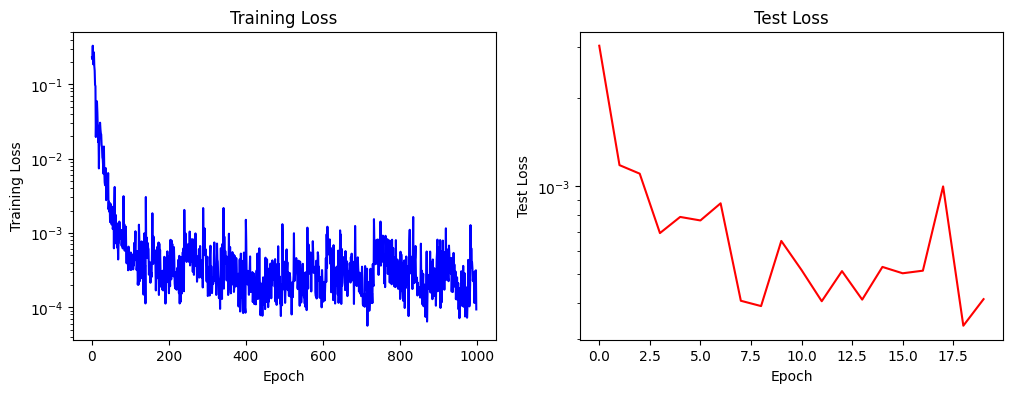

In [ ]:
# plot loss history for training and test sets
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(loss_history_train)), loss_history_train, label='train', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.yscale('log')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(loss_history_test)), loss_history_test, label='test', color='red')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.yscale('log')
plt.title('Test Loss')

### Model evaluation

[Test] resolution_test:  64
[Dataset] downsampled raw data - x_data: torch.Size([2048, 64]), y_data: torch.Size([2048, 64])
[Dataset] x_train: torch.Size([1000, 64, 2]), y_train: torch.Size([1000, 64])
[Dataset] x_test: torch.Size([200, 64, 2]), y_test: torch.Size([200, 64])
[Test] resolution_test:  256
[Dataset] downsampled raw data - x_data: torch.Size([2048, 256]), y_data: torch.Size([2048, 256])
[Dataset] x_train: torch.Size([1000, 256, 2]), y_train: torch.Size([1000, 256])
[Dataset] x_test: torch.Size([200, 256, 2]), y_test: torch.Size([200, 256])
[Test] resolution_test:  1024
[Dataset] downsampled raw data - x_data: torch.Size([2048, 1024]), y_data: torch.Size([2048, 1024])
[Dataset] x_train: torch.Size([1000, 1024, 2]), y_train: torch.Size([1000, 1024])
[Dataset] x_test: torch.Size([200, 1024, 2]), y_test: torch.Size([200, 1024])


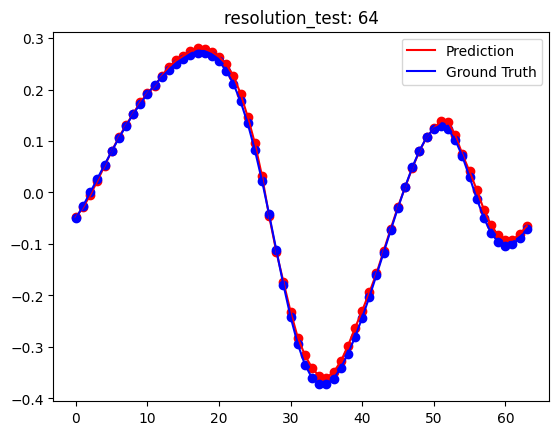

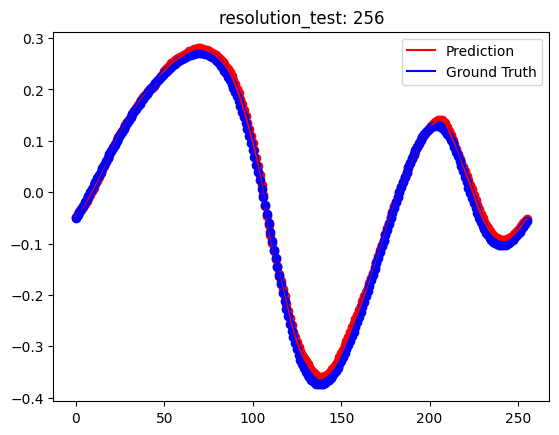

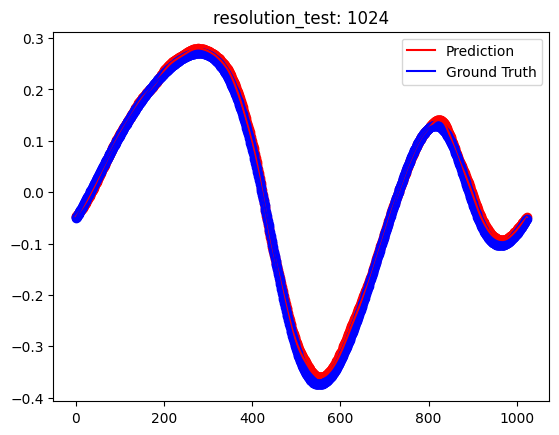

In [ ]:
resolution_test_list = [64, 256, 1024] # resolution for test data, which can be different from the resolution of training data

for resolution_test in resolution_test_list:
    print('[Test] resolution_test: ', resolution_test)
    sub = cfg.resolution_original // resolution_test
    _, test_loader = prepare_data(raw_data, sub, cfg)
    
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()
            pred = model(x)

    # plot comparison
    plt.figure()
    plt.plot(pred[0].cpu().numpy(), 'r', label='Prediction')
    plt.plot(y[0].cpu().numpy(), 'b', label='Ground Truth')
    plt.scatter(np.arange(resolution_test), pred[0].cpu().numpy(), c='r')
    plt.scatter(np.arange(resolution_test), y[0].cpu().numpy(), c='b')
    plt.legend(loc='upper right')
    plt.title(f'resolution_test: {resolution_test}')

# Reference

- FNO paper: Li, Z., Kovachki, N., Azizzadenesheli, K., Liu, B., Bhattacharya, K., Stuart, A., & Anandkumar, A. (2020). Fourier neural operator for parametric partial differential equations. arXiv preprint arXiv:2010.08895
- FNO official github: https://github.com/neuraloperator/neuraloperator/?tab=readme-ov-file
- FNO tutorial: https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_operators/simple_FNO_in_JAX.ipynb
- DeepONet & FNO: https://github.com/lu-group/deeponet-fno
- FNO documentation: https://neuraloperator.github.io/neuraloperator/dev/user_guide/neural_operators.html
- FNO blog: https://zongyi-li.github.io/blog/2020/fourier-pde/
- FNO news: https://www.technologyreview.com/2020/10/30/1011435/ai-fourier-neural-network-cracks-navier-stokes-and-partial-differential-equations/
- Wikipedia: https://en.wikipedia.org/wiki/Neural_operators
- Julia: https://docs.sciml.ai/NeuralOperators/stable/introduction/